In [1]:
import numpy as np
import pandas as pd
import re
import copy
import gensim

Using TensorFlow backend.


In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Conv1D, Embedding, Dropout, Activation, Flatten
from keras.layers import GlobalMaxPool1D, MaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

### Read in training data

In [6]:
full_train = pd.read_csv('../train.csv')
full_train.shape

(95851, 8)

In [7]:
labels = np.array(full_train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']])

In [8]:
clean_comment = np.zeros(shape=[labels.shape[0]])
clean_comment[np.max(labels,axis=1)==0] = 1

In [9]:
comments=full_train['comment_text'].tolist()

In [10]:
token_dict = {}
token_set = set()
tokenized_comments = copy.copy(comments)
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = re.sub("\n",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("\t",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    tokenized_comments[i] = tokenized_comments[i].split(' ')
    line_dict = {}
    line_set = set()
    for token in tokenized_comments[i]:        
        if token in token_set:
            token_dict[token] += 1
        else:
            token_set.add(token)
            token_dict[token] = 1

### Read in test data

In [12]:
testdat = pd.read_csv('../test.csv')

In [13]:
test_comments0 = testdat['comment_text'].tolist()

In [14]:
test_comments0 = testdat['comment_text'].tolist()
test_comments = copy.copy(test_comments0)
for i in range(len(test_comments)):
    if type(test_comments[i]) is float:
        print(i,test_comments[i])
        test_comments[i]=[]
    else:
        test_comments[i] = re.sub("\n",' ',test_comments[i])
        test_comments[i] = re.sub("\t",' ',test_comments[i])
        test_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',test_comments[i])
        test_comments[i] = re.sub(" +",' ',test_comments[i])
        test_comments[i] = re.sub("'+","'",test_comments[i])    
        test_comments[i] = re.sub("\*+","\*",test_comments[i])   
        test_comments[i] = re.sub("\-+","\-",test_comments[i])
        test_comments[i] = test_comments[i].lower().strip()
        test_comments[i] = test_comments[i].split(' ')
        for token in test_comments[i]:        
            if token in token_set:
                token_dict[token] += 1
            else:
                token_set.add(token)
                token_dict[token] = 1        

52300 nan


In [15]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']

In [16]:
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
token_count = token_count.reset_index()

In [17]:
reduced_token_count = token_count[token_count['freq']>=15]
reduced_token_count.shape
reduced_token_set = set(reduced_token_count['token'])

In [18]:
reduced_token_count.sample(5)

,index,token,freq
15153,15153,titling,45
21458,21458,milosevic,26
8656,8656,cartoons,112
7916,7916,sidebar,130
17225,17225,dang,37


#### Convert training sequences to index

In [19]:
index_token_dict = pd.Series(reduced_token_count.token.values,index=reduced_token_count.index+1).to_dict()
token_index_dict = pd.Series(reduced_token_count.index.values+1,index=reduced_token_count.token).to_dict()

In [20]:
tokenized_corpus = []
for line in tokenized_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_corpus += [line_token_idx]

In [21]:
print(tokenized_comments[0])
print(tokenized_corpus[0])

['nonsense', 'kiss', 'off', 'geek', 'what', 'i', 'said', 'is', 'true', "i'll", 'have', 'your', 'account', 'terminated']
[853, 2316, 340, 9168, 53, 9, 216, 8, 396, 326, 22, 24, 218, 13547]


In [22]:
comment_length = []
for comment in tokenized_comments:
    comment_length.append(len(comment))
comment_length = np.array(comment_length)
np.percentile(comment_length,80)

90.0

(0, 600)

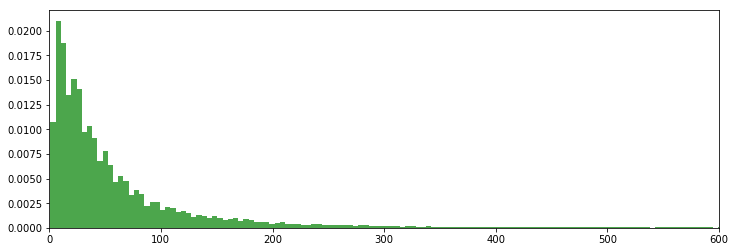

In [25]:
plt.figure(figsize=(12, 4))
n, bins, patches = plt.hist(comment_length, 300, normed=1, facecolor='green', alpha=0.7)
plt.xlim([0,600])

In [27]:
MAX_SEQ_LENGTH=300
tokenized_corpus_padded = pad_sequences(tokenized_corpus,maxlen=MAX_SEQ_LENGTH)

### Load w2v model

In [29]:
w2v_model = gensim.models.Word2Vec.load("../wiki_comment_word2vec")

In [30]:
len(w2v_model.wv.vocab)

31293

In [31]:
V = len(reduced_token_set)+1
EMBEDDING_DIM=50
print((V,EMBEDDING_DIM))

(31294, 50)


In [32]:
embed_matrix = np.zeros((V,EMBEDDING_DIM))
for token in token_index_dict.keys():
    embed_matrix[token_index_dict[token]] = w2v_model.wv[token]

In [33]:
embed_matrix.shape

(31294, 50)

### Split training data into train,valid sets

In [34]:
labels0,tokenized_corpus_padded0 = shuffle(labels,tokenized_corpus_padded)

In [35]:
labels_train,labels_valid, \
seq_train,seq_valid  = \
train_test_split(labels0,tokenized_corpus_padded0,\
                 test_size=0.2,stratify=clean_comment)

In [36]:
print(np.mean(labels_train,axis=0))
print(labels_train.shape)
print(np.mean(labels_valid,axis=0))
print(labels_valid.shape)

[ 0.09663537  0.01014606  0.05340376  0.0031951   0.04990871  0.00851591]
(76680, 6)
[ 0.09530019  0.00975432  0.05289239  0.00312973  0.04892807  0.0083981 ]
(19171, 6)


### Lightweight convolutional model

In [37]:
# Sequence input
sequence_input = Input(shape=(MAX_SEQ_LENGTH,),dtype='int32',name='Input')

# Embedding lookup
embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM
                              ,weights=[embed_matrix]
                              ,input_length=MAX_SEQ_LENGTH
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [55]:
# Convolutional layers: width 7
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(embed_seq_unmasked)
Conv7_layer = MaxPooling1D(2)(Conv7_layer)
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(Conv7_layer)
Conv7_layer = GlobalMaxPool1D()(Conv7_layer)
Conv7_layer = Dropout(0.5)(Conv7_layer)

In [58]:
#Conv_dense = Dense(50,activation='relu')(Conv_cat)
Conv_dense = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(Conv7_layer)
Conv_output = Dense(6, activation="sigmoid")(Conv_dense)

In [59]:
cnn_model = Model(inputs=sequence_input, outputs=Conv_output)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 300)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 300, 50)           1564700   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 300, 64)           22464     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 150, 64)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 150, 64)           28736     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

In [60]:
history_CNN = cnn_model.fit(seq_train,labels_train
                           ,epochs=6
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/6
76680/76680 [==============================] - 246s - loss: 0.0779 - acc: 0.9753 - val_loss: 0.0574 - val_acc: 0.9802
Epoch 2/6
76680/76680 [==============================] - 246s - loss: 0.0595 - acc: 0.9795 - val_loss: 0.0562 - val_acc: 0.9804
Epoch 3/6
76680/76680 [==============================] - 246s - loss: 0.0558 - acc: 0.9804 - val_loss: 0.0544 - val_acc: 0.9803
Epoch 4/6
76680/76680 [==============================] - 247s - loss: 0.0540 - acc: 0.9808 - val_loss: 0.0552 - val_acc: 0.9801
Epoch 5/6
76680/76680 [==============================] - 248s - loss: 0.0523 - acc: 0.9812 - val_loss: 0.0548 - val_acc: 0.9804
Epoch 6/6
76680/76680 [==============================] - 243s - loss: 0.0509 - acc: 0.9816 - val_loss: 0.0557 - val_acc: 0.9807


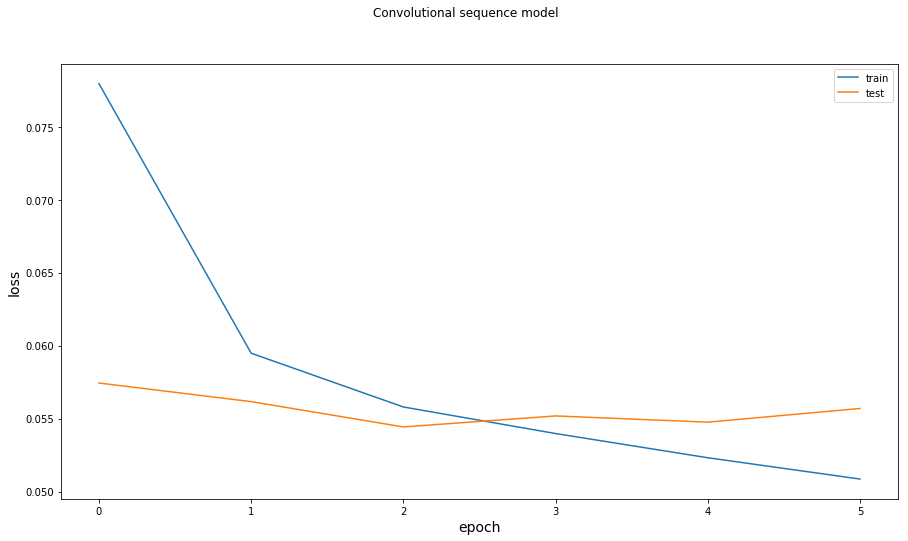

In [61]:
plt.figure(figsize=(15,8))
plt.suptitle("Convolutional sequence model")
#plt.subplot(121)
plt.plot(history_CNN.history['loss'],label='train')
plt.plot(history_CNN.history['val_loss'],label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)
#plt.subplot(122)
#plt.plot(history_CNN.history['acc'],label='train')
#plt.plot(history_CNN.history['val_acc'],label='test')
#plt.legend()
#plt.xlabel('epoch',fontsize=14)
#plt.xlabel('accuracy',fontsize=14)

#### Kaggle test set scoring

In [62]:
tokenized_test = []
for line in test_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_test += [line_token_idx]

In [63]:
tokenized_test_padded = pad_sequences(tokenized_test,maxlen=MAX_SEQ_LENGTH)

In [64]:
cnn_kaggle_predict = cnn_model.predict(tokenized_test_padded)

In [70]:
print(np.mean(labels,axis=0))
print(np.mean(cnn_kaggle_predict,axis=0))
print(np.std(cnn_kaggle_predict,axis=0))

[ 0.09636832  0.01006771  0.05330148  0.00318202  0.04971257  0.00849235]
[ 0.02999607  0.00317678  0.0161566   0.00089962  0.01500889  0.00288092]
[ 0.1318257   0.02953791  0.10475662  0.00495702  0.0941691   0.01922035]


In [97]:
pd.DataFrame(cnn_kaggle_predict).corr()

,0,1,2,3,4,5
0,1.000000,0.757358,0.940088,0.907769,0.953271,0.892138
1,0.757358,1.000000,0.884630,0.880673,0.895212,0.961345
2,0.940088,0.884630,1.000000,0.906447,0.995845,0.952970
3,0.907769,0.880673,0.906447,1.000000,0.933600,0.968418
4,0.953271,0.895212,0.995845,0.933600,1.000000,0.968963
5,0.892138,0.961345,0.952970,0.968418,0.968963,1.000000


(0, 0.1)

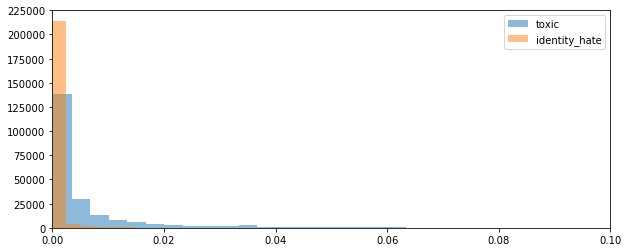

In [84]:
plt.figure(figsize=(10, 4))
n, bins, patches = plt.hist(cnn_kaggle_predict[:,0], 300, normed=0, alpha=0.5,label='toxic')
n, bins, patches = plt.hist(cnn_kaggle_predict[:,5], 100, normed=0, alpha=0.5,label='identity_hate')
plt.legend()
plt.xlim([0,0.1])

(0, 1)

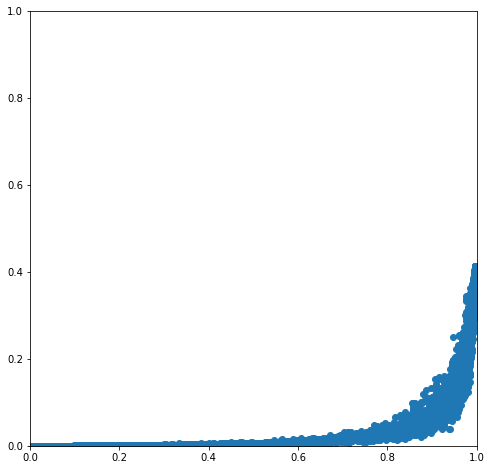

In [99]:
plt.figure(figsize=(8, 8))
plt.scatter(cnn_kaggle_predict[:,0],cnn_kaggle_predict[:,1])
plt.ylim([0,1])
plt.xlim([0,1])